# CIFAR10 CNN

Train a simple deep CNN on the CIFAR10 small images dataset.

Some constants we'll use:

In [1]:
batch_size = 32
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20

In [2]:
from conx import *

Using Theano backend.
conx, version 3.5.9


In [3]:
net = Network("CIRAR10")
net.add(ImageLayer("input", (32, 32), 3)) # depends on K.image_data_format(), right?
net.add(Conv2DLayer("conv1", 32, (3, 3), padding='same', activation='relu'))
net.add(Conv2DLayer("conv2", 32, (3, 3), activation='relu'))
net.add(MaxPool2DLayer("pool1", pool_size=(2, 2), dropout=0.25))
net.add(Conv2DLayer("conv3", 64, (3, 3), padding='same', activation='relu'))
net.add(Conv2DLayer("conv4", 64, (3, 3), activation='relu'))
net.add(MaxPool2DLayer("pool2", pool_size=(2, 2), dropout=0.25))
net.add(FlattenLayer("flatten"))
net.add(Layer("hidden1", 512, activation='relu', vshape=(16, 32), dropout=0.5))
net.add(Layer("output", num_classes, activation='softmax'))
net.connect()

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

net.compile(loss='categorical_crossentropy',
            optimizer=opt)

# Let's train the model using RMSprop
net.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model = net.model

In [4]:
net.dataset.get("cifar10")

In [5]:
net.dataset.summary()

**Dataset name**: CIFAR-10


Original source: https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10
classes, with 6000 images per class.

The classes are completely mutually exclusive. There is no overlap
between automobiles and trucks. "Automobile" includes sedans, SUVs,
things of that sort. "Truck" includes only big trucks. Neither
includes pickup trucks.

**Dataset Split**:
   * training  : 60000
   * testing   : 0
   * total     : 60000

**Input Summary**:
   * shape  : [(32, 32, 3)]
   * range  : [(0.0, 1.0)]

**Target Summary**:
   * shape  : [(10,)]
   * range  : [(0.0, 1.0)]



In [6]:
net.dataset._inputs[0].shape

(60000, 32, 32, 3)

In [7]:
net.dataset.split(50000)
net.dataset.summary()

**Dataset name**: CIFAR-10


Original source: https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10
classes, with 6000 images per class.

The classes are completely mutually exclusive. There is no overlap
between automobiles and trucks. "Automobile" includes sedans, SUVs,
things of that sort. "Truck" includes only big trucks. Neither
includes pickup trucks.

**Dataset Split**:
   * training  : 10000
   * testing   : 50000
   * total     : 60000

**Input Summary**:
   * shape  : [(32, 32, 3)]
   * range  : [(0.0, 1.0)]

**Target Summary**:
   * shape  : [(10,)]
   * range  : [(0.0, 1.0)]



## Examine Input as Image

In [8]:
net.dataset.inputs.shape

[(32, 32, 3)]

In [9]:
net.dataset.targets.shape

[(10,)]

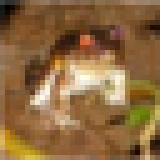

In [10]:
image = array2image(net.dataset.inputs[0], scale=5.0)
image

In [11]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('', 'input', 'conv1', 'conv2', 'pool1', 'conv3', 'conv4', 'pool2'), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=9, options=('input', 'conv1', 'conv2', 'pool1', 'conv3', 'conv4', 'pool2', 'flatten', 'hidden1', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
net.propagate(net.dataset.inputs[1])

[0.0949893519282341,
 0.09791158884763718,
 0.10104776173830032,
 0.10612580180168152,
 0.09653763473033905,
 0.10584577172994614,
 0.0927908718585968,
 0.10790029913187027,
 0.0942075327038765,
 0.10264338552951813]

## Let Keras Take over from here

In [67]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

In [68]:
import numpy as np

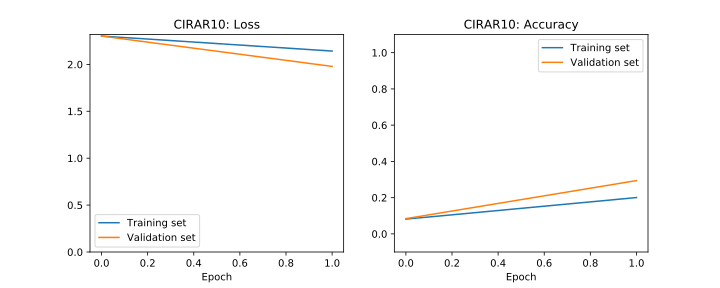

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#    1 |   2.14204 |   0.20052 |   1.97837 |   0.29421 


In [34]:
net.train(plot=True)

In [69]:
shape(x_test), shape(y_test)

((1, 50000, 32, 32, 3), (1, 50000, 10))

In [70]:
model = net.model

In [71]:
(x_train, y_train), (x_test, y_test) = net.dataset._split_data()

In [72]:
shape(x_train), shape(y_train), shape(x_test), shape(y_test)

((1, 10000, 32, 32, 3), (1, 10000, 10), (1, 50000, 32, 32, 3), (1, 50000, 10))

In [57]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train[0])

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train[0], y_train[0],
                                     batch_size=batch_size),
                        steps_per_epoch=x_train[0].shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Using real-time data augmentation.
Epoch 1/200
313/312 [==============================] - 219s 700ms/step - loss: 1.6980 - acc: 0.3732 - val_loss: 1.5751 - val_acc: 0.4305
Epoch 2/200
313/312 [==============================] - 225s 718ms/step - loss: 1.6487 - acc: 0.3901 - val_loss: 1.5533 - val_acc: 0.4324
Epoch 3/200
311/312 [============================>.] - ETA: 0s - loss: 1.6029 - acc: 0.4136

KeyboardInterrupt: 

In [76]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test[0], y_test[0],
                                      batch_size=batch_size),
                                      steps=x_test[0].shape[0] // batch_size)

print('Model Accuracy = %.2f' % (evaluation[1]))

predict_gen = model.predict_generator(datagen.flow(x_test[0], y_test[0],
                                      batch_size=batch_size),
                                      steps=x_test[0].shape[0] // batch_size)

for predict_index, predicted_y in enumerate(predict_gen):
    #actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
    #predicted_label = labels['label_names'][np.argmax(predicted_y)]
    #print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
    #                                                      predicted_label))
    print('Actual Label = %s vs. Predicted Label = %s' % (y_test[0][predict_index],
                                                          predicted_y))
    if predict_index == num_predictions:
        break

Model Accuracy = 0.43
Actual Label = [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.] vs. Predicted Label = [ 0.07781513  0.11049026  0.0632093   0.02424265  0.10382453  0.04574762
  0.03441789  0.42630658  0.02449505  0.08945103]
Actual Label = [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.] vs. Predicted Label = [ 0.02727769  0.19264257  0.02373797  0.01587937  0.0090649   0.00988456
  0.06715904  0.01502883  0.06517704  0.57414806]
Actual Label = [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.] vs. Predicted Label = [ 0.05388747  0.72588551  0.00831101  0.00158087  0.00303652  0.00182245
  0.00224504  0.00250599  0.10607026  0.0946549 ]
Actual Label = [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.] vs. Predicted Label = [ 0.01729291  0.19587232  0.07844362  0.10607366  0.05843127  0.09728301
  0.20552364  0.0685864   0.01614707  0.15634608]
Actual Label = [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.] vs. Predicted Label = [ 0.04557527  0.47399527  0.04536494  0.04711241  0.02142892  0.03853729
  0.02306257  0.03